In [1]:
import os
import copy
import numpy as np
from scipy import signal, stats, constants
from scipy.optimize import minimize, curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from helper import custom_contcolorbar

ModuleNotFoundError: No module named 'scipy'

# Simple hard-coded MCMC

This part of the notebook codes a brute-force MCMC sampler for the acoustic geometry calibration of P-ONE. It is based on pseudo experiments and expected uncertainties on various relevant parameters to sample the parameter space and find the most-likely reconstruction of a receiver.

Due to the estimated prior uncertainties on various parameters (e.g. speed of sound, beacon position, timing) these pseudo experiments will show a spread that determines the achievable calibration resolution. This resolution can be investigated as a function of the various parameter uncertainties, so that conclusions for the design can be drawn.

## Geometry definition

In [2]:
d0   = 50. # m

beacons = {'test'   : [[0, 0],
                       [0, 5.],
                       [0, 0]],
           'minimal': [[0, d0, d0],
                       [0, d0, -d0],
                       [0, 0, 0]],
           'extend' : [[0, d0, d0, -d0, -d0],
                       [0, d0, -d0, d0, -d0],
                       [0, 0, 0, 0, 0]],
           'p-one'  : [[12.3, 36.9, 62.3, 37.2, -12.7, -37.2, -12.7],
                       [-21.3, -64.6, -21, 21.9, 21.9, -21.9, -62.3],
                       [0, 0, 0, 0, 0, 0, 0]],
            }

receiver = np.array([[10],
                     [20],
                     [50]])

for key in beacons:
    beacons[key] = np.array(beacons[key], dtype=float)
    
for key in beacons:
    x, y, z    = beacons[key]
    xr, yr, zr = receiver
    dist       = np.sqrt((x-xr)**2 + (y-yr)**2 + (z-zr)**2)
    print('%s %s' %(key, dist))

test [54.77225575 53.15072906]
minimal [54.77225575 70.71067812 94.86832981]
extend [ 54.77225575  70.71067812  94.86832981  83.66600265 104.88088482]
p-one [ 64.89206423 101.88606382  83.1642351   56.95129498  54.94451747
  80.51987332  98.93725284]


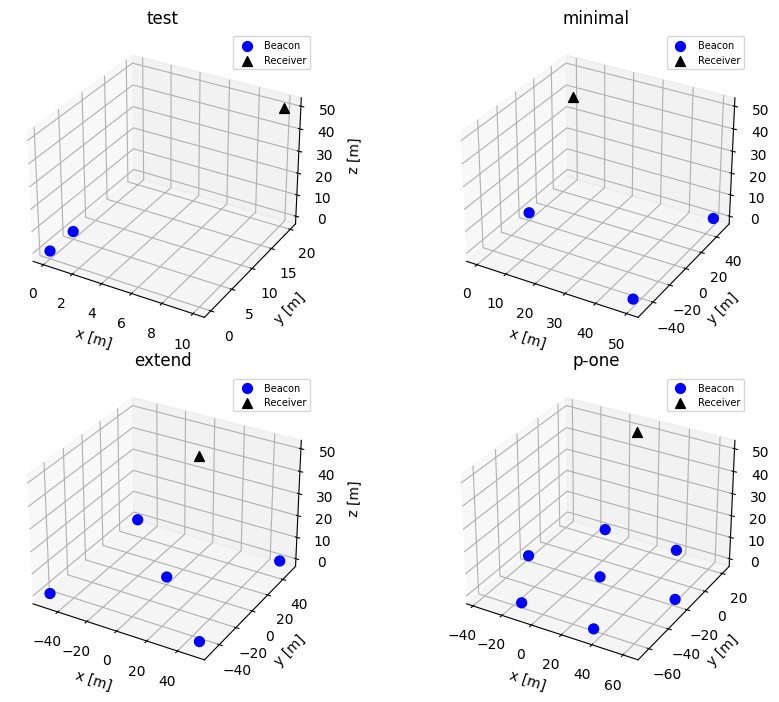

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,7), subplot_kw={'projection': '3d'})
axs = axs.flatten()

nb = len(beacons)

# draw beacons
for i, key in enumerate(beacons):
    
    x, y, z = beacons[key]
    
    # draw beacons
    axs[i].scatter(x, y, z, marker='o', color='blue', s=50, alpha=1, label='Beacon')
    
    # draw receivers
    x, y, z = receiver
    axs[i].scatter(x, y, z, marker='^', color='black', s=50, label='Receiver')
        
    # format
    axs[i].set_title(key)
    axs[i].set_xlabel('x [m]')
    axs[i].set_ylabel('y [m]')
    axs[i].set_zlabel('z [m]')
    axs[i].legend(loc='upper right', fontsize=7)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, right=0.9)
plt.show()

## Priors, parameter uncertainties

**ONC beacon position**

$x_i = x_{0,i}  \pm  2 \,$m in ( 𝑥 ,  𝑦 ,  𝑧 )

**Speed of sound**  

$v_s = 1520  \pm  20 \,\frac{m}{s}$ [1]

[1] https://www.sciencedirect.com/science/article/pii/S0304420315300475

**Resolution**

$\sigma_{spatial} \approx 15 \, \mu s \sim$ Piezo size [2]

$\sigma_{ADC} \approx 1.5 \, \mu s \sim$  ADC sampling at $768\,\text{kHz}$

$\sigma_{sync} \approx 5 \, \mu s \sim$  Synchronization

$\sigma_{Shannon} = 1\,\text{bit} \, / \left( \frac{1}{t_{recording}} \cdot \sum_\omega \log_2 \left( 1 + \text{SNR}(\omega) \right) \right) \approx 10 - 100\,\mu s$ [2]

[2] https://www.institut3b.physik.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaatmdetx

Assuming all resolutions affect the arrival time measurement independently, and roughly follow a Gaussian distribution, we have

$ \sigma_{total} = \sqrt{ \sum_i \sigma_i^2 } \approx \begin{cases} 17.2\;\mu s \quad \sigma_{shannon} = 10\, \mu s\\ 101\;\mu s \quad \sigma_{shannon} = 100\, \mu s\end{cases} $

Using the fact that we have a known distance of $50 \pm 0.2\,m$ to measure the speed of sound at roughly $1500\,\frac{m}{s} $ with a time of flight of roughly

$t_{50m} \approx \frac{50\,m}{1520\,\frac{m}{s}} = 32 894.7 \,\mu s$

allows us to estimate the uncertainty on the measurement of the speed of sound to be

$v = \frac{d}{t} \rightarrow \sigma_v = |v| \cdot \sqrt{ \left(\frac{\Delta d}{d}\right)^2 + \left(\frac{\Delta t}{t}\right)^2 } = \begin{cases} 6.1\,\frac{m}{s} \quad \sigma_{shannon} = 10\, \mu s\\ 7.6\,\frac{m}{s} \quad \sigma_{shannon} = 100\, \mu s \end{cases}$

Finally, we can translate this time and velocity resolution to a positional resolution

$x = \frac{v}{t} \rightarrow \sigma_x = |x| \cdot \sqrt{ \left(\frac{\Delta v}{v}\right)^2 + \left(\frac{\Delta t}{t}\right)^2 }$

In [4]:
# speed of sound
c0  = 1520 # m/s
d_c0 = 20 # m/s

# acoustic resolutions
# taken from: https://www.institut3b.physik.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaatmdetx
# especially Table 4.1, Figure 4.5
d_spatial = 13e-6 # us
d_adc = 1.5e-6 # us
d_sync = 5e-6 # us
d_shannon = 100e-6 # us
# this is an estimate based on longest attenuation length in ice = 300m
# in water: http://resource.npl.co.uk/acoustics/techguides/seaabsorption/ (F=15, T=3, D=2.5, S=35, pH=8)
# gives sound absorption, a, within [1.392, 1.706] db/km
# in 1/km this becomes a' = a * (ln(10)/10)
# for a = 1.5 db/km --> attenuation length = 1 / a' = 1 / (a * (ln(10)/10)) = 2.8km ~ 10 * attenuation length ice
# so we use d_shannon ~ d_shannon_icecube / 10
d_t = np.sqrt(d_spatial**2 + d_adc**2 + d_sync**2 + d_shannon**2)

# beacon placement accuracy
d_beacon = 2. # m

## Minimization scheme

Minimize the following function

$\chi^2 = \frac{\sum_i \left( t_i - \left( \frac{\sqrt{(x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2}}{v_s}\right)\right)^2}{\Delta t^2 \cdot N_{beacon}}$

where $x_i, y_i, z_i$ are the coordinates of the beacons, $x,y,z$ are the coordinates of the receiver, $t_i$ is the nominal time of flight, $v$ is the speed of sound in water, $\Delta t$ the nominal time error, and $N_{beacon}$ the number of used beacons.

$x_i, y_i, z_i, v_s, t_i$ are varied according to the Markov method and their proposed uncertainties.

$x, y, z$ are fit.

In [5]:
def calc_distances(coords, receiver=receiver):
    x, y, z    = copy.deepcopy(coords)
    xr, yr, zr = receiver
    dist       = np.sqrt((x-xr)**2 + (y-yr)**2 + (z-zr)**2)
    return dist

def calc_times(coords, receiver=receiver):
    t0 = distances(coords, receiver=receiver) / c0
    return t0

In [6]:
def gaussian(x, a, mu, sig):
    return a * np.exp(-(x-mu)**2/(2*sig**2))

def fit_gaussian(x, bins=100, r=(), sigma=0.1, tol=0.):
    n, e = np.histogram(x, range=r, bins=bins)
    c    = (e[:-1] + e[1:]) / 2.
    a0   = np.max(n)
    mu0  = c[(n == np.max(n))][0]
    sig0 = sigma
    m = (n >= tol*n)
    popt, pcov = curve_fit(gaussian, c[m], n[m], p0=(a0, mu0, sig0), maxfev=10000)
    return popt

In [7]:
def ctxyz(coords, d_t=d_t, d_c0=d_c0, d_beacon_xy=d_beacon, d_beacon_z=d_beacon):
    x,y,z    = copy.deepcopy(coords)
    dt      = np.random.normal(loc=0, scale=d_t)
    c       = c0 + np.random.normal(loc=0, scale=d_c0)
    x       += np.random.normal(loc=0, scale=d_beacon_xy,  size=x.shape)
    y       += np.random.normal(loc=0, scale=d_beacon_xy,  size=y.shape)
    z       += np.random.normal(loc=0, scale=d_beacon_z,  size=z.shape)
    return c, dt, np.array([x,y,z])

def chi2(p, w_coords, w_c, w_dt, r0):
    xi, yi, zi = p
    x, y, z = copy.deepcopy(w_coords)
    n_b     = len(x)
    r       = np.sqrt((x-xi)**2 + (y-yi)**2 + (z-zi)**2)
    t       = r/w_c
    t0      = r0/c0 + w_dt
    dt2     = (t - t0)**2
    chi2    = np.sum(dt2/(d_t**2 * n_b))
    return chi2

## Brute-force MCMC

In [8]:
key    = 'extend'
data   = copy.deepcopy(beacons[key])
r0     = calc_distances(data)

nrun   = 1000
ndim   = 3
bounds = [[i-500, i+500] for i in receiver.flatten()[:ndim]]
bounds[-1][0] = 1

############################### RUN
chain = np.zeros((nrun, ndim))
for i in range(nrun):
        coords     = copy.deepcopy(data)
        w_c, w_dt, w_xyz = ctxyz(coords, d_t=d_t, d_c0=d_c0, d_beacon_xy=d_beacon/20, d_beacon_z=d_beacon/20)
        p_xyz      = np.random.uniform(low=-100, high=100, size=(3,))
        x0         = [*p_xyz]
        soln       = minimize(chi2, x0=x0, args=(w_xyz, w_c, w_dt, r0), bounds=bounds)
        if soln.success:
            chain[i] = soln.x
        else:
            chain[i] = [np.nan for i in range(ndim)]
        if i>0 and i%1000 == 0:
            print('%s - %i processed.' %(key, i))

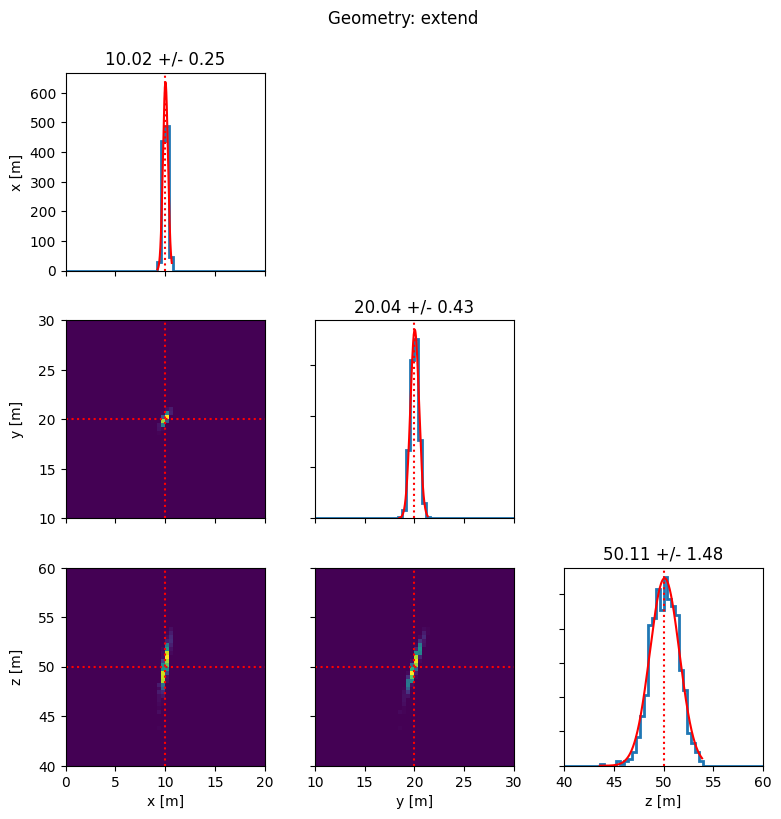

In [9]:
############################### PLOT
bins = 50
trth = [*receiver.flatten()]
lbls = ['x [m]', 'y [m]', 'z [m]']
lims = [[-100, 100], [-100, 100], [-100, 100] ]
lims = [[0, 20], [10, 30], [40, 60]]
#lims = [[5, 15], [15, 25], [40, 60]]
#lims = [[8, 12], [18, 22], [45, 55]]
#lims = [[9.5, 10.5], [19.5, 20.5], [49.5, 50.5]]

fig  = plt.figure(figsize=(9,9))
gs   = fig.add_gridspec(ndim, ndim, hspace=0.25, wspace=0.25)

for i in range(ndim):
               
    for j in range(ndim):
        
        li0, li1 = lims[i][0], lims[i][1]
        lj0, lj1 = lims[j][0], lims[j][1]
        
        if j <= i:
            ax = fig.add_subplot(gs[i:i+1, j:j+1])
            ax.set_xlim(lj0, lj1)
            
        # plot hist
        if i == j:
            # truths
            ax.axvline(trth[i], color='red', ls=':')
            # mcmc hist
            x    = chain[:,i]
            n, e = np.histogram(x, bins=bins, range=(li0, li1))
            # fit
            xfit = np.linspace(np.nanmin(x), np.nanmax(x), 1000)
            try:
                popt = fit_gaussian(x, bins=bins, r=(li0, li1), sigma=.1, tol=0.1)
            except:
                popt = [np.nan, np.nan, np.nan]
            # plot
            ax.stairs(n, e, lw=2)
            ax.plot(xfit, gaussian(xfit, *popt), color='red')
            # title
            ax.set_title('%.2f +/- %.2f' %(popt[1], popt[2]))
            
        # plot scatter
        if i > j:
            # limits
            ax.set_ylim(li0, li1)
            # truths
            ax.scatter(trth[j], trth[i], marker='x', color='red')
            ax.axvline(trth[j], color='red', ls=':')
            ax.axhline(trth[i], color='red', ls=':')
            H, yedges, xedges = np.histogram2d(chain[:,i], chain[:,j], bins=bins, 
                                               range=[[li0, li1], [lj0, lj1]]
                                              )
            ax.pcolormesh(xedges, yedges, H)
            
        if i > 0 and j > 0:
            ax.tick_params(axis='y', which='both', labelleft=False)
            
        if i < ndim-1:
            ax.tick_params(axis='x', which='both', labelbottom=False) 
            
        if j == 0:
            ax.set_ylabel(lbls[i])
        
        if i == ndim-1:
            ax.set_xlabel(lbls[j])
            
fig.suptitle('Geometry: %s' %(key), y=0.95)
fig.align_ylabels()
plt.show()

## Find resolution impact

In [10]:
nrun   = 1000
ndim   = 3
bounds = [[i-500, i+500] for i in receiver.flatten()[:ndim]]
bounds[-1][0] = 1
resolutions = np.logspace(-1, np.log10(5), 5)

popts = {}
for key in ['minimal', 'extend', 'p-one']:
    
    data = copy.deepcopy(beacons[key])
    r0   = calc_distances(data)
    
    popts_tmp = []
    for i, res in enumerate(resolutions):

        chain = np.zeros((nrun, ndim))
        for j in range(nrun):
                coords     = copy.deepcopy(data)
                w_c, w_dt, w_xyz = ctxyz(coords, d_t=d_t, d_c0=d_c0, d_beacon_xy=res, d_beacon_z=res)
                p_xyz      = np.random.uniform(low=-100, high=100, size=(3,))
                x0         = [*p_xyz]
                soln       = minimize(chi2, x0=x0, args=(w_xyz, w_c, w_dt, r0), bounds=bounds)
                if soln.success:
                    chain[j] = soln.x
                else:
                    chain[j] = [np.nan for i in range(ndim)]

        # mcmc hist
        popt_tmp = []
        for k in range(ndim-1):

            # limits
            li       = [*receiver.flatten()]
            li0, li1 = li[k] - 10*res, li[k] + 10*res

            # fit
            x    = chain[:,k]
            n, e = np.histogram(x, bins=bins, range=(li0, li1))
            xfit = np.linspace(x.min(), x.max(), 1000)
            try:
                popt = fit_gaussian(x, bins=bins, r=(li0, li1), sigma=res)
            except:
                popt = [np.nan, np.nan, np.nan]

            print(key, i, k, res, popt)
            popt_tmp.append(popt[-1])

        resolution = np.nanmean(popt_tmp)
        popts_tmp.append(resolution)
        
    popts[key] = popts_tmp

minimal 0 0 0.1 [15.0825688   9.88946882  1.1088261 ]
minimal 0 1 0.1 [30.19718054 20.01881656  0.52660086]
minimal 1 0 0.26591479484724945 [36.07402737 10.0077878   1.18519212]
minimal 1 1 0.26591479484724945 [67.13972096 19.98798016  0.63423231]
minimal 2 0 0.7071067811865475 [67.89299324  9.98382933  1.61112524]
minimal 2 1 0.7071067811865475 [107.70624516  19.93327355   1.01643534]
minimal 3 0 1.8803015465431967 [86.11330287  9.99880817  3.20075524]
minimal 3 1 1.8803015465431967 [121.71126457  20.08978097   2.26388124]
minimal 4 0 5.000000000000001 [86.02278347  8.99476573  8.46102571]
minimal 4 1 5.000000000000001 [115.4714397   20.43395301   6.67048821]
extend 0 0 0.1 [73.58881536  9.99383442  0.21808289]
extend 0 1 0.1 [39.63845185 19.98197983  0.40237723]
extend 1 0 0.26591479484724945 [141.9363066   10.02405078   0.29382603]
extend 1 1 0.26591479484724945 [93.50275729 19.98964987  0.45135921]
extend 2 0 0.7071067811865475 [176.53736784   9.95948234   0.63698819]
extend 2 1 0.

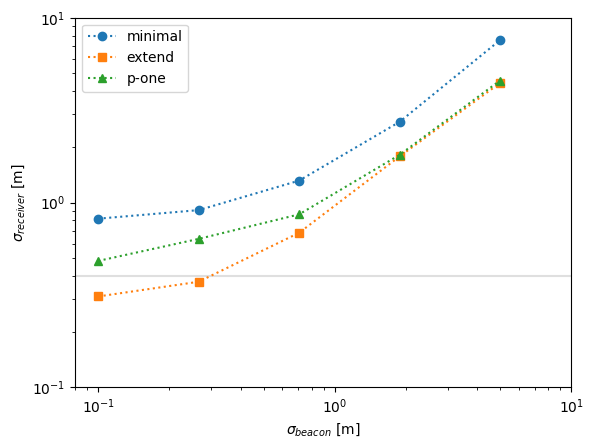

In [11]:
markers = ['o', 's', '^']

plt.figure()
for i, key in enumerate(['minimal', 'extend', 'p-one']):
    x = resolutions
    y = popts[key]
    plt.plot(x, y, ls=':', marker=markers[i], label='%s' %(key), zorder=100)
plt.xlabel('$\sigma_{beacon}$ [m]')
plt.ylabel('$\sigma_{receiver}$ [m]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(8e-2, 1e1)
plt.ylim(1e-1, 1e1)
plt.axhline(0.4, color='grey', alpha=0.25)
plt.legend()
plt.show()

---